## Preamble

In [1]:
import random

import numpy

from matplotlib import patches
from matplotlib import pyplot
from sklearn import linear_model

In [2]:
# Our dataset of 100 (x_j, y_j) data pairs.
N = 100
rng = random.Random("Let's fool around with Lasso")
XS = numpy.array(list(sorted(rng.uniform(-3, 3) for _ in range(N)))).reshape(-1, 1)
YS = numpy.array([xi + rng.gauss(0, 0.4) for xi in XS]).reshape(-1, 1)

X_LIMS = [XS[0], XS[-1]]

# Reg-strength lambda values for "none", some" and "lots" of regularization.
# The "none" regularization strength is set, for the numerical computing
# concerns of `linear_model.Lasso` to merely very-very-close to zero.
THREE_LAMBDAS = (0.49, 350, 800)
LAM_ZERO, LAM_LO, LAM_HI = THREE_LAMBDAS

The blog post defines the univariate Lasso objective as:

$$w_{BLOG}^*(\lambda) := \arg \min_w \sum_{j=1}^N{\left(wx_j - y_j\right)^2} + \lambda|w|$$

The cost function `f` embedded in there is the sum of squared errors.  But
[SciKit-Learn's `linear_model.Lasso` uses](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html)
a gentle variation on the cost function, targeting half the *average* squared error:

$$w_{SKL}^*(\alpha) := \arg \min_w \frac{1}{2N}\sum_{j=1}^N{\left(wx_j - y_j\right)^2} + \alpha|w|$$

These are just positive-value-rescalings of each other, and you recover the same model
weight if you translate between those scale factors:

$$w_{BLOG}^*(\lambda) = w_{SKL}^*\left(\frac{\lambda}{2N}\right)$$
$$w_{SKL}^*(\alpha) = w_{BLOG}^*\left(2N\alpha\right)$$

and the following two helper functions will let us do those translations, so that the
graphs we plot can speak the same reg-strength-units as the blog post (even though
SKLearn doesn't).

In [3]:
def lambda_to_alpha(lamb: float) -> float:
    return (lamb / (2 * N))

def alpha_to_lambda(alpha: float) -> float:
    return (alpha * 2 * N)

## "What's Lasso? (A convex optimization.)"

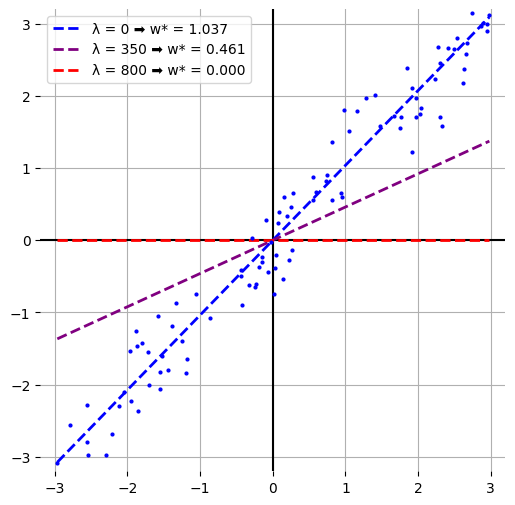

In [4]:
fig = pyplot.figure(figsize=(6, 6))
ax = fig.gca()
ax.axhline(color='k')
ax.axvline(color='k')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

colors = ['blue', 'purple', 'red']
for (color, lamb) in zip(colors, THREE_LAMBDAS):
    model = linear_model.Lasso(alpha=lambda_to_alpha(lamb), fit_intercept=False)
    model.fit(XS, YS)
    y_hats = model.predict(X_LIMS)
    label = f'λ = {lamb:0.0f} ➡️ w* = {model.coef_[0]:0.3f}'
    ax.plot(X_LIMS, y_hats, color=color, label=label,
            linestyle='--', linewidth=2)
ax.plot(XS, YS, 'b.', markersize=4)
ax.set_xlim(-3.2, 3.2)
ax.set_ylim(-3.2, 3.2)
ax.grid()
ax.legend()

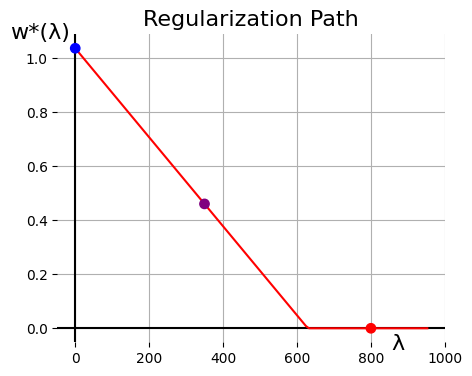

In [5]:
fig = pyplot.figure(figsize=(5, 4))
ax = fig.gca()
ax.axhline(color='k')
ax.axvline(color='k')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

alpha = 0.001
coef = 1000
while coef > 1e-6:
    model = linear_model.Lasso(alpha=alpha, fit_intercept=False)
    model.fit(XS, YS)
    coef = model.coef_[0]
    #print(f'{alpha:0.3e}, {coef:0.3e}')
    alpha *= 1.17

coefs = []
lambdas = []
for lamb in numpy.arange(LAM_ZERO, (1.2 * LAM_HI), LAM_HI/100):
    model = linear_model.Lasso(alpha=lambda_to_alpha(lamb), fit_intercept=False)
    model.fit(XS, YS)
    coef = model.coef_[0]
    lambdas.append(lamb)
    coefs.append(coef)

special_coefs = []
for lamb in THREE_LAMBDAS:
    model = linear_model.Lasso(alpha=lambda_to_alpha(lamb), fit_intercept=False)
    model.fit(XS, YS)
    special_coefs.append(model.coef_[0])

ax.text(LAM_HI + 90, -0.02, 'λ', va='top', ha='right', fontsize=16)
ax.text(-14, 1.07, 'w*(λ)', ha='right', fontsize=16)
ax.set_title('Regularization Path', fontsize=16)

ax.scatter(THREE_LAMBDAS, special_coefs, c=['blue', 'purple', 'red'], s=45, zorder=2.5)
ax.plot(lambdas, coefs, 'r-', markersize=3)
ax.grid()    

## "What's Lasso doing? (Parabolas.)

In [6]:
# The blog's aliases for sum-of-squares and dot-product data summaries.
S_X = sum(xi * xi for xi in XS)
D_XY = sum(xi * yi for (xi, yi) in zip(XS, YS))
S_Y = sum(yi * yi for yi in YS)

In [7]:
# The domain of model parameters over which we eval the objective functions.
WS = numpy.arange(-0.2, 2.2, 0.01)
# The model weights we get from Lasso @ {zero, LAM_LO, LAM_HI}
W_ZERO = D_XY / S_X
W_LO = (2 * D_XY - LAM_LO)/(2 * S_X)
W_HI = 0

In [8]:
def f_ols(w: float) -> float:
    """Evaluates the OLS loss function for our blue-dot dataset."""
    return S_X * w * w - 2 * D_XY * w + S_Y

# The loss function `f` evaluated over the weight domain:
FS = [S_X * w * w - 2 * D_XY * w + S_Y for w in WS]

In [9]:
def parabola_canvas() -> (pyplot.Figure, pyplot.Axes):
    """Returns standard figure and axes for plotting Lasso parabolas."""
    fig = pyplot.figure(figsize=(6, 4))
    ax = fig.gca()
    ax.axhline(color='k')
    ax.axvline(color='k')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.set_ylim(-20, 500)
    ax.text(2.2, 5, 'w', va='bottom', ha='right', fontsize=16)
    ax.grid()
    return fig, ax

### "Zero regularization"

[1.03782033] [13.88969475]


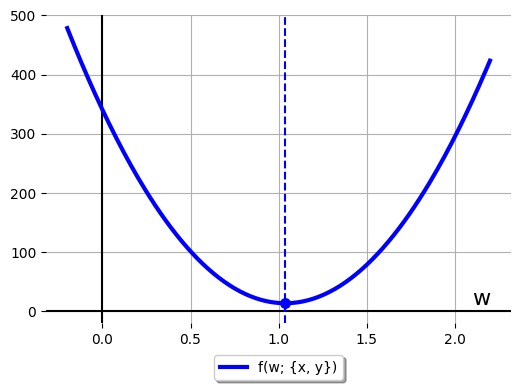

In [21]:
_, ax = parabola_canvas()
ax.plot(WS, FS, color='blue', linewidth=3, label='f(w; {x, y})')
ax.scatter([W_ZERO,], f_ols(W_ZERO),
           color='blue', s=47)
ax.axvline(x=W_ZERO, color='blue', linestyle='--')
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.08),
          fancybox=True, shadow=True, ncol=5)
print(W_ZERO, f_ols(W_ZERO))

### "Some regularization"

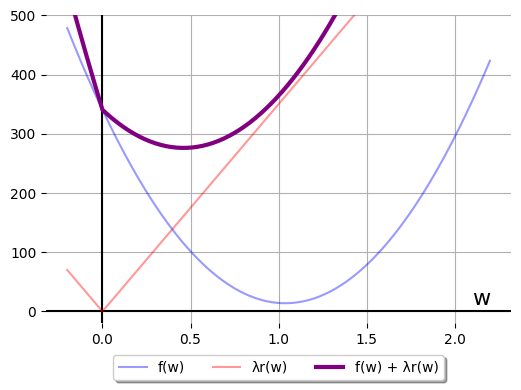

In [11]:
r_los = [LAM_LO * abs(w) for w in WS]
obj_los = [fi + ri for (fi, ri) in zip(FS, r_los)]

_, ax = parabola_canvas()
ax.plot(WS, FS, color='blue', alpha=0.4, label='f(w)')
ax.plot(WS, r_los, color='red', alpha=0.4, label='λr(w)')
ax.plot(WS, obj_los, color='purple', linewidth=3, label='f(w) + λr(w)')
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.08),
          fancybox=True, shadow=True, ncol=5)

/tmp/ipykernel_16077/910367969.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  arr = patches.FancyArrowPatch((float(W_ZERO), 400.0), (float(W_LO), 400.0),


Text(0.5, 1, '-λ/(2Sx)')

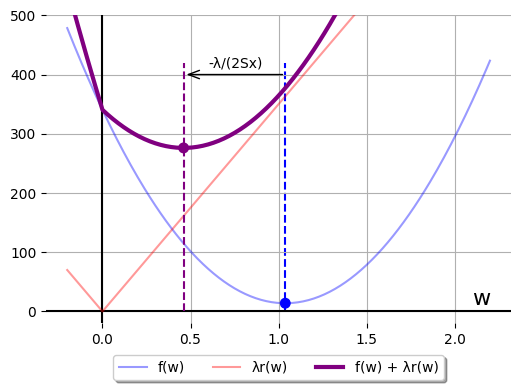

In [20]:
_, ax = parabola_canvas()
ax.plot(WS, FS, color='blue', alpha=0.4, label='f(w)')
ax.plot(WS, r_los, color='red', alpha=0.4, label='λr(w)')
ax.plot(WS, obj_los, color='purple', linewidth=3, label='f(w) + λr(w)')
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.08),
          fancybox=True, shadow=True, ncol=5)
ax.scatter(
    [W_ZERO, W_LO],
    [f_ols(W_ZERO), f_ols(W_LO) + LAM_LO * W_LO],
    c=['blue', 'purple'],
    s=47    
)
ax.plot([W_ZERO, W_ZERO], [0, 420], color='blue', linestyle='--', zorder=0)
ax.plot([W_LO, W_LO], [0, 420], color='purple', linestyle='--')
arr = patches.FancyArrowPatch((float(W_ZERO), 400.0), (float(W_LO), 400.0),
                              arrowstyle='->,head_width=.15', mutation_scale=20,
                              zorder=100)
ax.add_patch(arr)
ax.annotate("-λ/(2Sx)", (.5, 1), xycoords=arr, ha='center', va='bottom')

### "Lots of regularization"

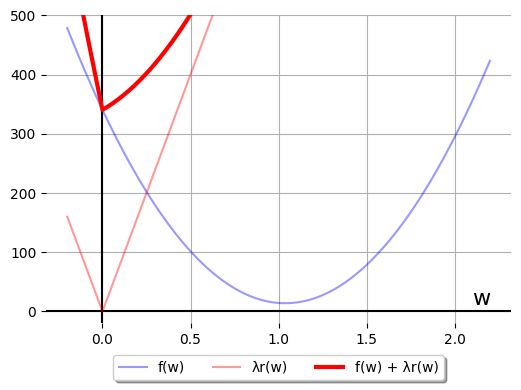

In [13]:
r_his = [LAM_HI * abs(w) for w in WS]
obj_his = [fi + ri for (fi, ri) in zip(FS, r_his)]

_, ax = parabola_canvas()
ax.plot(WS, FS, color='blue', alpha=0.4, label='f(w)')
ax.plot(WS, r_his, color='red', alpha=0.4, label='λr(w)')
ax.plot(WS, obj_his, color='red', linewidth=3, label='f(w) + λr(w)')
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.08),
          fancybox=True, shadow=True, ncol=5)